In [146]:

from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import time
import numpy as np
from sklearn import metrics
import pandas as pd
import pprint
import random


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import pickle
import os 
import pretty_errors
plt.rcdefaults()

In [147]:
if os.path.abspath(os.getcwd()) != 'c:\\Users\\tdufl\\Documents\\WPC\\WPC_Python_driver_release':
    os.chdir("..")

In [148]:
def merge_data_sets(df1, df2):
    df2['ID'] += df1['ID'].max()
    df2['index'] += df1['index'].max() + 1
    return pd.concat([df1, df2])


def equal_sample_dataset(df, sample_size):
    x_rows = pd.Series(df[df.Type == 'X_acc'].ID.unique()).sample(n = sample_size)
    y_rows = pd.Series(df[df.Type == 'Y_acc'].ID.unique()).sample(n = sample_size)
    z_rows = pd.Series(df[df.Type == 'Z_acc'].ID.unique()).sample(n = sample_size)

    x_rows = df[df.ID.isin(x_rows)]
    y_rows = df[df.ID.isin(y_rows)]
    z_rows = df[df.ID.isin(z_rows)]

    return pd.concat([x_rows, y_rows, z_rows])

In [149]:
neutraldf1 = pd.read_csv('data_sensor/test_acc_C1_V0.csv')
neutraldf2 = pd.read_csv('data_sensor/test_acc_C2_V0.csv')

neutraldf_mov = merge_data_sets(neutraldf1, neutraldf2)
neutraldf_mov = equal_sample_dataset(neutraldf_mov, 27)


freezedf = pd.read_csv('data_sensor/test_neutral.csv')
freezedf_id_sample = pd.Series(freezedf.ID.unique()).sample(n=27)
freezedf = freezedf[freezedf.ID.isin(freezedf_id_sample)]

neutraldf = merge_data_sets(neutraldf_mov, freezedf)
neutraldf['Type'] = 'Neutral'

oridf= pd.read_csv('data_sensor/Test_ori_V0_3s.csv')


alldf = merge_data_sets(neutraldf, oridf)
alldf.reset_index(drop=True, inplace=True)

all_data = alldf.copy()
DR = np.pi / 180

Create the columns diff Roll/ Yaw that measure how Roll and Yaw diverge from one to an other

Difficult moment to guess : when yaw and roll are close to critic values

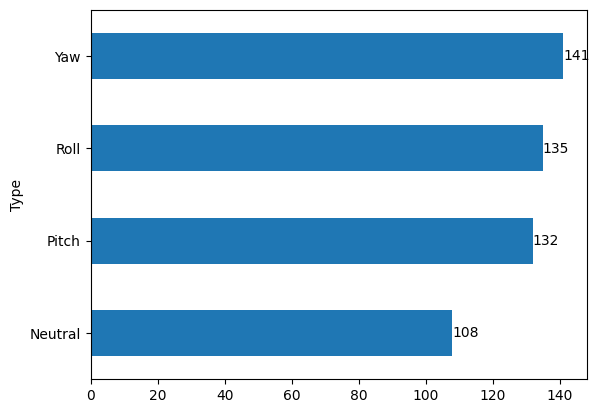

In [150]:
all_data = alldf.copy()
DR = np.pi / 180

ax = nb_by_type = all_data.groupby('Type').ID.nunique().plot.barh()
ax.bar_label(ax.containers[0])
alldf['diff_Roll'] = alldf['Roll'].diff()
alldf['diff_Pitch'] = alldf['Pitch'].diff()
alldf['diff_Yaw'] = alldf['Yaw'].diff()
alldf['X_acc'] = alldf['X_acc'] - 9.81* np.sin(DR * alldf['Pitch'])
alldf['Y_acc'] = alldf['Y_acc'] - 9.81 * np.sin(DR * alldf['Roll'])*np.cos(DR * alldf['Pitch'])
alldf['Z_acc'] = alldf['Z_acc'] - 9.81 * np.cos(DR * alldf['Roll'])*np.cos(DR * alldf['Pitch'])


alldf['SinRoll'] = np.sin(DR*alldf['Roll'])
alldf['SinPitch'] = np.sin(DR*alldf['Pitch'])
alldf['SinYaw'] = np.sin(DR*alldf['Yaw'])

alldf['diff_SinRoll'] = alldf['SinRoll'].diff()
alldf['diff_SinPitch'] = alldf['SinPitch'].diff()
alldf['diff_SinYaw'] = alldf['SinYaw'].diff()

alldf['RatioRoll'] = alldf['diff_Roll']**2 / (alldf['diff_Pitch'] * alldf['diff_Yaw']) 
alldf['RatioPitch'] = alldf['diff_Pitch']**2 / (alldf['diff_Roll'] * alldf['diff_Yaw'])
alldf['RatioYaw'] = alldf['diff_Yaw']**2 / (alldf['diff_Roll'] * alldf['diff_Pitch'])

alldf['RatioSinRoll'] = alldf['diff_SinRoll']**2 / (alldf['diff_SinPitch'] * alldf['diff_SinYaw'])
alldf['RatioSinPitch'] = alldf['diff_SinPitch']**2 / (alldf['diff_SinRoll'] * alldf['diff_SinYaw'])
alldf['RatioSinYaw'] = alldf['diff_SinYaw']**2 / (alldf['diff_SinRoll'] * alldf['diff_SinPitch'])

alldf['Roll_and_Yaw'] = alldf['Roll'] - alldf['Yaw']
alldf['diff_Roll_and_Yaw'] = alldf['Roll_and_Yaw'].diff()

alldf['Sin_Roll_and_Yaw'] = alldf['SinRoll'] - alldf['SinYaw']
alldf['diff_Sin_Roll_and_Yaw'] = alldf['Sin_Roll_and_Yaw'].diff()

alldf['double_pitch'] = alldf['Pitch'] * 2

alldf.dropna(inplace=True, axis = 0)

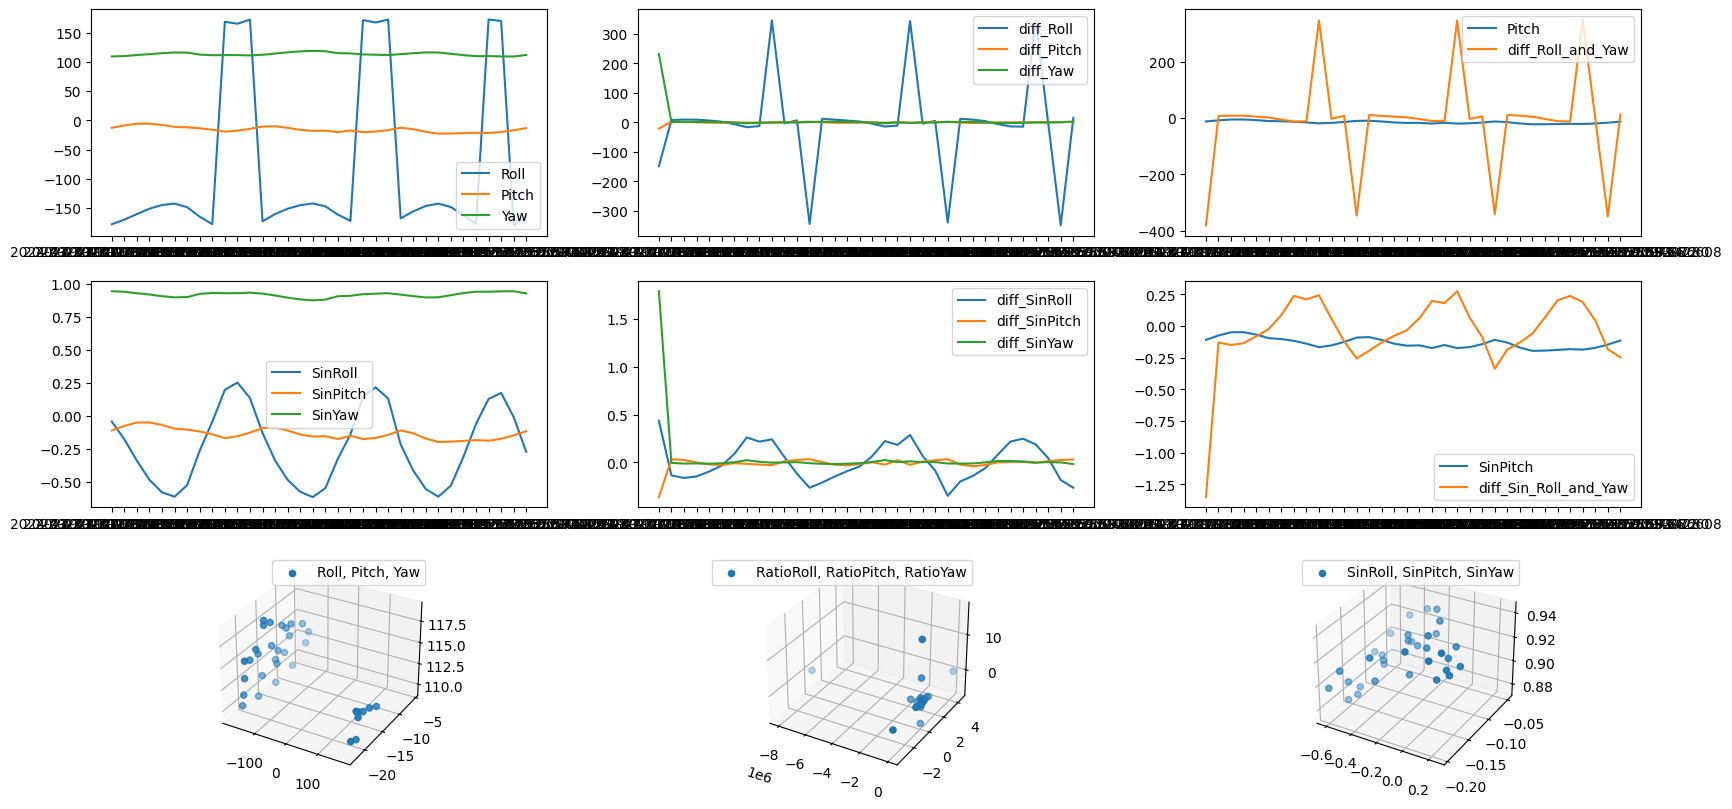

Roll


In [151]:
ID_plot = alldf['ID'].sample(n = 1)
ID_plot = ID_plot.iloc[0]
Roll = alldf[alldf['ID'] == ID_plot]['Roll']
Pitch = alldf[alldf['ID'] == ID_plot]['double_pitch']
Yaw = alldf[alldf['ID'] == ID_plot]['Yaw']

diff_Roll = alldf[alldf['ID'] == ID_plot]['diff_Roll']
diff_Pitch = alldf[alldf['ID'] == ID_plot]['diff_Pitch']
diff_Yaw = alldf[alldf['ID'] == ID_plot]['diff_Yaw']

SinRoll = alldf[alldf['ID'] == ID_plot]['SinRoll']
SinPitch = alldf[alldf['ID'] == ID_plot]['SinPitch']
SinYaw = alldf[alldf['ID'] == ID_plot]['SinYaw']

diff_SinRoll = alldf[alldf['ID'] == ID_plot]['diff_SinRoll']
diff_SinPitch = alldf[alldf['ID'] == ID_plot]['diff_SinPitch']
diff_SinYaw = alldf[alldf['ID'] == ID_plot]['diff_SinYaw']

RatioRoll = alldf[alldf['ID'] == ID_plot]['RatioRoll']
RatioPitch = alldf[alldf['ID'] == ID_plot]['RatioPitch']
RatioYaw = alldf[alldf['ID'] == ID_plot]['RatioYaw']

RatioSinRoll = alldf[alldf['ID'] == ID_plot]['RatioSinRoll']
RatioSinPitch = alldf[alldf['ID'] == ID_plot]['RatioSinPitch']
RatioSinYaw = alldf[alldf['ID'] == ID_plot]['RatioSinYaw']

Roll_and_Yaw = alldf[alldf['ID'] == ID_plot]['Roll_and_Yaw']
diff_Roll_and_Yaw = alldf[alldf['ID'] == ID_plot]['diff_Roll_and_Yaw']

Sin_Roll_and_Yaw = alldf[alldf['ID'] == ID_plot]['Sin_Roll_and_Yaw']
diff_Sin_Roll_and_Yaw = alldf[alldf['ID'] == ID_plot]['diff_Sin_Roll_and_Yaw']

t = alldf[alldf['ID'] == ID_plot]['Time']

tlabel = alldf[alldf['ID'] == ID_plot]['Type'].iloc[0]

numeric_cols = alldf.select_dtypes(include=['int64', 'float64'])
for col in numeric_cols:
    alldf[col] = alldf[col].clip(lower = -100000000, upper = 100000000)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(3, 3, 1)
ax1.plot(t,Roll, label = 'Roll')
ax1.plot(t,Pitch, label = 'Pitch')
ax1.plot(t,Yaw, label = 'Yaw')
ax1.legend()

ax2 = fig.add_subplot(3, 3, 2)
ax2.plot(t,diff_Roll, label = 'diff_Roll')
ax2.plot(t,diff_Pitch, label = 'diff_Pitch')
ax2.plot(t,diff_Yaw, label = 'diff_Yaw')
ax2.legend()

ax3 = fig.add_subplot(3, 3, 3)
ax3.plot(t, Pitch, label = 'Pitch')
ax3.plot(t, diff_Roll_and_Yaw, label = 'diff_Roll_and_Yaw')
ax3.legend()

ax4 = fig.add_subplot(3, 3, 4)
ax4.plot(t,SinRoll, label = 'SinRoll')
ax4.plot(t,SinPitch, label = 'SinPitch')
ax4.plot(t,SinYaw, label = 'SinYaw')
ax4.legend()

ax5 = fig.add_subplot(3, 3, 5)
ax5.plot(t,diff_SinRoll, label = 'diff_SinRoll')
ax5.plot(t,diff_SinPitch, label = 'diff_SinPitch')
ax5.plot(t,diff_SinYaw, label = 'diff_SinYaw')
ax5.legend()

ax6 = fig.add_subplot(3, 3, 6)
ax6.plot(t, SinPitch, label = 'SinPitch')
ax6.plot(t, diff_Sin_Roll_and_Yaw, label = 'diff_Sin_Roll_and_Yaw')
ax6.legend()

ax7 = fig.add_subplot(3, 3, 7, projection = '3d')
ax7.scatter(Roll, Pitch, Yaw, label = 'Roll, Pitch, Yaw')
ax7.legend()

ax8 = fig.add_subplot(3, 3, 8, projection = '3d')
ax8.scatter(RatioRoll, RatioPitch, RatioYaw, label = 'RatioRoll, RatioPitch, RatioYaw')
ax8.legend()

ax9 = fig.add_subplot(3, 3, 9, projection = '3d')
ax9.scatter(SinRoll, SinPitch, SinYaw, label = 'SinRoll, SinPitch, SinYaw')
ax9.legend()

plt.legend()
plt.show()

print(tlabel)
#seems great

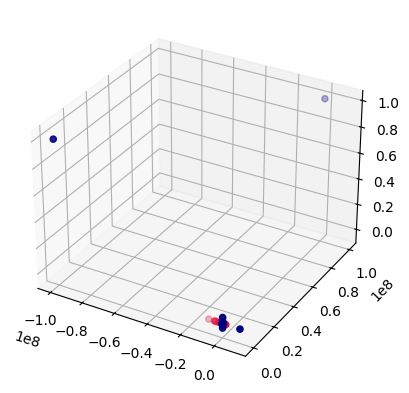

In [152]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
RollCloud = alldf[alldf['Type'] == 'Roll'][['RatioRoll', 'RatioPitch', 'RatioYaw']]
PitchCloud = alldf[alldf['Type'] == 'Pitch'][['RatioRoll', 'RatioPitch', 'RatioYaw']]
YawCloud = alldf[alldf['Type'] == 'Yaw'][['RatioRoll', 'RatioPitch', 'RatioYaw']]

ax.scatter(RollCloud['RatioRoll'], RollCloud['RatioPitch'], RollCloud['RatioYaw'], color = 'crimson')
ax.scatter(PitchCloud['RatioRoll'], PitchCloud['RatioPitch'], PitchCloud['RatioYaw'], color = 'forestgreen')
ax.scatter(YawCloud['RatioRoll'], YawCloud['RatioPitch'], YawCloud['RatioYaw'], color = 'navy')

In [153]:
mapping = {"Roll" : 0, "Pitch" : 1, "Yaw" : 2}

y = alldf['Type'].map(mapping)
fig = px.scatter_3d(alldf, x = 'RatioRoll', y = 'RatioPitch', z = 'RatioYaw', color = 'Type')
scale = 1000
fig.update_layout(scene=dict(
                    xaxis=dict(range=[-scale, scale]),
                    yaxis=dict(range=[-scale, scale]),
                    zaxis=dict(range=[-scale, scale])
                    ))
fig

Le résultat est très bon, on pourrait presque faire du clustering

### Dumb Random Forrest

In [154]:
def get_split_train_test(X):
    n_id = alldf[alldf['Type'] == 'Roll'].ID.unique().shape[0]

    i = 0 
    while i == 0:
        ## Get a unique list of ID
        aa = alldf.copy()
        pd_id = aa.drop_duplicates(subset = 'ID', keep = 'first')
        pd_id = pd_id[['ID', 'Type']]

        ##Create random number between 0 and 1

        pd_id['boogie'] = (np.random.rand(len(pd_id)))
        pd_id['Modeling_Group'] = np.where(pd_id['boogie'] > 0.7, 'Test', 'Train')
        pd_id_pivot = pd_id.pivot_table(index = 'Type', columns = 'Modeling_Group', aggfunc = 'size')
        # pd_id_pivot['Roll']['Test']
        test_values = pd_id_pivot.loc[:]['Test']
        i = test_values[(test_values > (n_id//3) * 0.9) & (test_values < (n_id//3) * 1.1)].shape[0] // 3

    pd_id = pd_id.drop(['Type'], axis = 1)
    X_data = pd.merge(X, pd_id, on = 'ID', how = 'left')
    #print(X_data.head())
    X_train = X_data[X_data['Modeling_Group'] == 'Train']
    y_train = X_train['Type']
    X_train = X_train.drop(['Type','boogie', 'Modeling_Group', 'ID_sample', 'Interval Time', 'Time', 'index_start'], axis = 1, errors = 'ignore')

    X_test = X_data[X_data['Modeling_Group'] == 'Test']
    y_test = X_test['Type']
    X_test = X_test.drop(['Type', 'boogie', 'Modeling_Group', 'ID_sample', 'Interval Time', 'Time', 'index_start'], axis = 1, errors = 'ignore')
    return X_data, X_train, y_train, X_test, y_test

X_data, X_train, y_train, X_test, y_test = get_split_train_test(alldf)
print(X_train.columns)

Index(['ID', 'Roll', 'Pitch', 'Yaw', 'X_acc', 'Y_acc', 'Z_acc', 'index',
       'diff_Roll', 'diff_Pitch', 'diff_Yaw', 'SinRoll', 'SinPitch', 'SinYaw',
       'diff_SinRoll', 'diff_SinPitch', 'diff_SinYaw', 'RatioRoll',
       'RatioPitch', 'RatioYaw', 'RatioSinRoll', 'RatioSinPitch',
       'RatioSinYaw', 'Roll_and_Yaw', 'diff_Roll_and_Yaw', 'Sin_Roll_and_Yaw',
       'diff_Sin_Roll_and_Yaw', 'double_pitch'],
      dtype='object')


In [155]:
def evaluate_model_tab(alg, X_train, y_train, X_test, y_test, accuracy_return : bool = False, plot : bool = False):
    y_test_ID = X_data[X_data['Modeling_Group'] == 'Test'][['ID', 'Type']]
    X_train = X_train.drop(['ID', 'lets_tab'], axis = 1, errors= 'ignore')
    print(f"columns : {X_train.columns}")
    X_test = X_test.drop(['ID', 'lets_tab'], axis = 1, errors= 'ignore')
    
    clf = alg.fit(X_train, y_train)
    #Predict training set:
    prediction = clf.predict(X_test)
    print(f"Confusion Matrix: \n{confusion_matrix(y_test, prediction)}")
    y_test_ID = X_data[X_data['Modeling_Group'] == 'Test'][['ID', 'Type']]
    y_test_ID['Prediction'] = prediction
    Y_result = y_test_ID.groupby('ID').agg(lambda x: pd.Series.mode(x)[0])

    try:
        feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)[:15]
        if plot:
            feat_imp.plot.bar()
            plt.ylabel('Feature Importance Score')
            plt.show()
    except:
        "No feature importance with this model"
    print(f"Dumb Accuracy: {clf.score(X_test, y_test):.2f}")
    print(f"Dumb F1 Score: {f1_score(y_test, prediction, average = 'weighted'):.2f}")
    print(f"Adapted Accuracy: {accuracy_score(Y_result['Type'], Y_result['Prediction']):.2f}")
    if accuracy_return:
        return round(accuracy_score(Y_result['Type'], Y_result['Prediction']),2)
    return clf



columns : Index(['diff_Roll', 'diff_Pitch', 'diff_Yaw'], dtype='object')


Confusion Matrix: 
[[ 203  138   83  214]
 [  44  934   37   59]
 [  59  103 1437   92]
 [ 137  109   61 1511]]


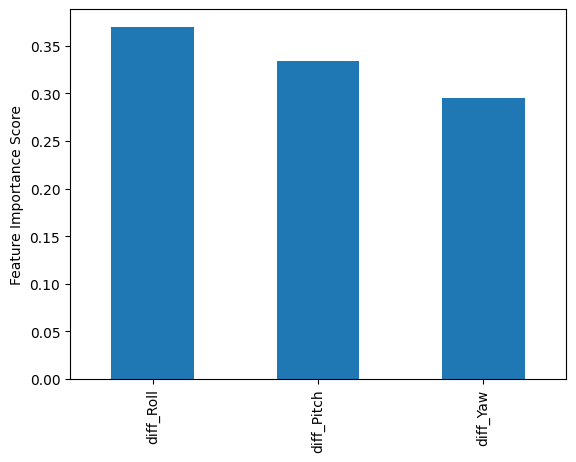

Dumb Accuracy: 0.78
Dumb F1 Score: 0.78
Adapted Accuracy: 0.82


In [156]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
rf = RandomForestClassifier(n_estimators = 10, max_depth = 5, random_state = 42)
clf = DecisionTreeClassifier()
## essayer avec Naive Bayes, KNN, and Logistic Regresssion
X_data, X_train, y_train, X_test, y_test = get_split_train_test(alldf[['ID', 'Type','diff_Roll', 'diff_Pitch', 'diff_Yaw']])
rf_tab = evaluate_model_tab(clf, X_train, y_train, X_test, y_test, accuracy_return=False, plot = True)

95 % d'accuracy sans même utiliser de tabularisation (sans neutral)

Knn, un peux meilleur que décision tree

In [157]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
## essayer avec Naive Bayes, KNN, and Logistic Regresssion
X_data, X_train, y_train, X_test, y_test = get_split_train_test(alldf[['ID', 'Type','RatioRoll', 'RatioPitch', 'RatioYaw']])
rf_tab = evaluate_model_tab(knn, X_train, y_train, X_test, y_test, accuracy_return=False, plot = True)

columns : Index(['RatioRoll', 'RatioPitch', 'RatioYaw'], dtype='object')
Confusion Matrix: 
[[  97  143   69  204]
 [  76 1658   77   77]
 [  56   86 1671   83]
 [  87  120  100 1481]]
Dumb Accuracy: 0.81
Dumb F1 Score: 0.80
Adapted Accuracy: 0.83


In [158]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

X_data, X_train, y_train, X_test, y_test = get_split_train_test(alldf[['ID', 'Type','RatioRoll', 'RatioPitch', 'RatioYaw']])
rf_tab = evaluate_model_tab(gnb, X_train, y_train, X_test, y_test, accuracy_return=False, plot = True)

columns : Index(['RatioRoll', 'RatioPitch', 'RatioYaw'], dtype='object')
Confusion Matrix: 
[[   4   17  527    0]
 [   0  383 1430    2]
 [   6   13 1691    0]
 [   9   18 1995    0]]
Dumb Accuracy: 0.34
Dumb F1 Score: 0.23
Adapted Accuracy: 0.26


In [159]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', gamma=10000)

X_data, X_train, y_train, X_test, y_test = get_split_train_test(alldf[['ID', 'Type','RatioRoll', 'RatioPitch', 'RatioYaw']])
rf_tab = evaluate_model_tab(gnb, X_train, y_train, X_test, y_test, accuracy_return=False, plot = True)

columns : Index(['RatioRoll', 'RatioPitch', 'RatioYaw'], dtype='object')
Confusion Matrix: 
[[   6   17  353    0]
 [   0  368 1341    3]
 [   3    2 1638    0]
 [  14   20 1784    0]]


Dumb Accuracy: 0.36
Dumb F1 Score: 0.25
Adapted Accuracy: 0.28


### Tabularize data

In [160]:
length_tab = 7
n_id = alldf[alldf['Type'] == 'Roll'].ID.unique().shape[0]

In [161]:
columns = ['ID', 'Type', 'Interval Time', 'Time', 'index']
other_cols = alldf.columns.difference(columns)
for cols in other_cols:
    for i in range(length_tab):
        columns.append(f"{cols}{i+1}")

wide_tab = pd.DataFrame(columns = columns)

lil_tab = alldf.copy()

In [162]:
lil_tab = lil_tab.sort_values(by = ['ID', 'Time'], ascending = [True, True])
lil_tab['flipper'] = np.where(lil_tab.ID != lil_tab.ID.shift(1), 1, 0)
#flipper : "time" when ID changes
index_flipper = lil_tab[lil_tab['flipper'] == 1]
index_flipper = index_flipper[['ID', 'index']]
index_flipper.rename({'index' : 'index_start'}, axis = 1, inplace = True)

lil_tab0 = lil_tab.merge(index_flipper, on = 'ID', how = 'left')

lil_tab0['index_start'] = lil_tab0['index'] - lil_tab0['index_start'] #not +1 because I don't want to consider the 
#first value of each sample
lil_tab0['lets_tab'] = np.where((lil_tab0.index_start >= length_tab), 1, 0)

In [163]:
for cols in other_cols:
    for i in range(length_tab):
        wide_tab[f"{cols}_{i+1}"] = lil_tab[cols].shift(i)

wide_tab["ID"] = lil_tab["ID"]
wide_tab["Type"] = lil_tab["Type"]
wide_tab["Interval Time"] = lil_tab["Interval Time"]
wide_tab["Time"] = lil_tab["Time"]
wide_tab['Time'] = pd.to_datetime(wide_tab['Time'])
wide_tab["index"] = lil_tab0["index_start"] - length_tab
wide_tab["lets_tab"] = lil_tab0["lets_tab"]
wide_tab = wide_tab[wide_tab["lets_tab"] == 1]

In [164]:
def get_split_train_test(dff = wide_tab, features = wide_tab.columns):
    extended_features = ['ID', 'Type', 'Interval Time', 'Time', 'index', 'lets_tab']
    for i in range(length_tab):
        for feat in features:
            extended_features.append(f"{feat}_{i+1}")
    tab = dff[extended_features]
    i = 0 
    while i == 0:
        ## Get a unique list of ID
        aa = dff.copy()
        pd_id = aa.drop_duplicates(subset = 'ID', keep = 'first')
        pd_id = pd_id[['ID', 'Type']]

        ##Create random number between 0 and 1

        pd_id['boogie'] = (np.random.rand(len(pd_id)))
        pd_id['Modeling_Group'] = np.where(pd_id['boogie'] > 0.7, 'Test', 'Train')
        pd_id_pivot = pd_id.pivot_table(index = 'Type', columns = 'Modeling_Group', aggfunc = 'size')
        # pd_id_pivot['Roll']['Test']
        test_values = pd_id_pivot.loc[:]['Test']
        i = test_values[(test_values > (n_id//3)*0.9) & (test_values < (n_id //3) * 1.1)].shape[0] // 3

    pd_id = pd_id.drop(['Type'], axis = 1)
    X_data = pd.merge(tab, pd_id, on = 'ID', how = 'left')
    #print(X_data.head())
    X_train = X_data[X_data['Modeling_Group'] == 'Train']
    y_train = X_train['Type']
    X_train = X_train.drop(['Type','boogie', 'Modeling_Group', 'index', 'Interval Time', 'Time'], axis = 1)

    X_test = X_data[X_data['Modeling_Group'] == 'Test']
    y_test = X_test['Type']
    X_test = X_test.drop(['Type', 'boogie', 'Modeling_Group', 'index', 'Interval Time', 'Time'], axis = 1)
    return X_data, X_train, y_train, X_test, y_test

print(X_train.columns)

Index(['ID', 'RatioRoll', 'RatioPitch', 'RatioYaw'], dtype='object')


In [165]:
def evaluate_model_tab(alg,tab, features, accuracy_return : bool = False, plot : bool = False):
    X_data, X_train, y_train, X_test, y_test = get_split_train_test(tab, features)
    y_test_ID = X_data[X_data['Modeling_Group'] == 'Test'][['ID', 'Type']]
    X_train = X_train.drop(['ID', 'lets_tab'], axis = 1)
    #print(f"columns : {X_train.columns}")
    X_test = X_test.drop(['ID', 'lets_tab'], axis = 1)
    
    clf = alg.fit(X_train, y_train)
    #Predict training set:
    prediction = clf.predict(X_test)
    print(f"Confusion Matrix: \n{confusion_matrix(y_test, prediction)}")
    y_test_ID = X_data[X_data['Modeling_Group'] == 'Test'][['ID', 'Type']]
    y_test_ID['Prediction'] = prediction
    Y_result = y_test_ID.groupby('ID').agg(lambda x: pd.Series.mode(x)[0])
    feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)[:15]
    if plot:
        feat_imp.plot.bar()
        plt.ylabel('Feature Importance Score')
        plt.show()
    print(f"Dumb Accuracy: {clf.score(X_test, y_test):.2f}")
    print(f"Adapted Accuracy: {accuracy_score(Y_result['Type'], Y_result['Prediction']):.2f}")
    if accuracy_return:
        return round(accuracy_score(Y_result['Type'], Y_result['Prediction']),2)
    return clf

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
rf = RandomForestClassifier(n_estimators = 10, max_depth = 5, random_state = 42)
clf = DecisionTreeClassifier()
## essayer avec Naive Bayes, KNN, and Logistic Regresssion
rf_tab = evaluate_model_tab(clf, wide_tab, ['X_acc', 'Y_acc', 'Z_acc','diff_Roll', 'diff_Pitch', 'diff_Yaw'], accuracy_return=False, plot = False)

Confusion Matrix: 
[[ 168   42   28   85]
 [  17 1437   44   89]
 [  21   77 1278   54]
 [  71   92   54 1604]]
Dumb Accuracy: 0.87
Adapted Accuracy: 0.91


### ResNet Test & Deep Learning

In [167]:
from tsai.all import *
import warnings

computer_setup()

os              : Windows-10-10.0.22631-SP0
python          : 3.9.13
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.2.1+cpu
device          : cpu
cpu cores       : 4
threads per cpu : 2
RAM             : 15.92 GB
GPU memory      : N/A


In [188]:
tdata = all_data.copy()
len_samples = 25
def mapping(angle):
    dict = {'Pitch' : -1, 'Roll' : 0, 'Yaw' : 1}
    return dict[angle]
def select_samples(tdata, ids, len_samples):
    samples = tdata[tdata['ID'] == ids]
    r = random.randint(0, samples.shape[0] - len_samples)
    samples = samples.iloc[r:r+len_samples]
    samples['index'] = [i for i in range(len_samples)]
    return samples
def tab_organized(tdata, len_samples):
    organized_tab = pd.DataFrame()
    tdata['ID_count'] = tdata.groupby('ID')['ID'].transform('count')
    tdata = tdata[tdata['ID_count'] >= 25]
    tdata = tdata.drop(['ID_count'], axis = 1)
    for ids in tdata['ID'].unique():
        samples = select_samples(tdata, ids, len_samples)
        organized_tab = pd.concat([organized_tab, samples])
    return organized_tab

tdata['Time'] = pd.to_datetime(tdata['Time'])

tdata = tab_organized(tdata, len_samples)
tdata.drop(['Time'],axis = 1, inplace = True)
tdata = tdata.reset_index(drop = True)

tdata['Type'] = tdata['Type'].map(mapping)
tdata.tail()

,ID,Type,Roll,Pitch,Yaw,X_acc,Y_acc,Z_acc,Interval Time,index
10045,1688,-1,-169.3120,-73.9256,-113.9238,-9.5130,0.1533,-1.3843,50,20
10046,1688,-1,-179.3501,-69.7682,-101.3707,-10.9596,-0.6514,-1.4179,50,21
10047,1688,-1,177.0728,-73.2515,-96.6929,-10.2219,0.0431,-0.2778,50,22
10048,1688,-1,175.9699,-82.6575,-96.1538,-10.4854,0.8287,2.4286,50,23
10049,1688,-1,3.4909,-70.8082,74.6075,-9.3310,0.3832,6.4618,50,24


In [ ]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

In [ ]:
#tree.plot_tree(clf)

In [ ]:
# pickle.dump(rf_tab, open('classifiers/clf_neutral_orientation_3s.pkl', 'wb'))

trouver les meilleurs features

In [ ]:
# import itertools
# sous_listes_test = list(itertools.combinations(other_cols, 3))
# dict_results = {}
# for l in sous_listes_test:
#     score = evaluate_model_tab(clf, wide_tab, l, accuracy_return=True, plot = False)
#     dict_results[l] = score
# print(f"Meilleur résultat : {max(dict_results, key=dict_results.get)} avec un score de {max(dict_results.values())}")

Resultat 99 % avec qqchose comme rationSInpitch difffroll and yaw et double pitch

### Prunning

In [ ]:
# X_data, X_train, y_train, X_test, y_test = get_split_train_test(wide_tab, ['diff_Roll', 'diff_Yaw', 'diff_Pitch'])
# clf = DecisionTreeClassifier(random_state=0)
# path = clf.cost_complexity_pruning_path(X_train, y_train)
# ccp_alphas, impurities = path.ccp_alphas, path.impurities

NameError: name 'ccp_alphas' is not defined

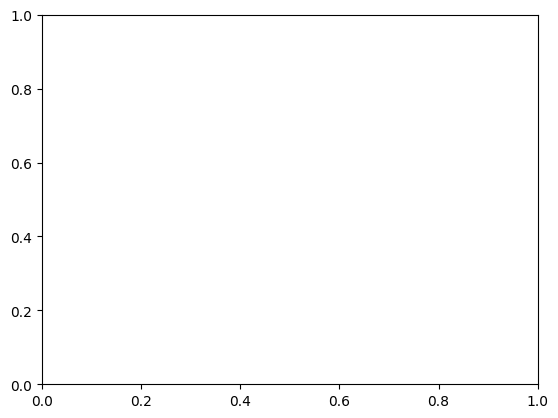

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.08390039495760915


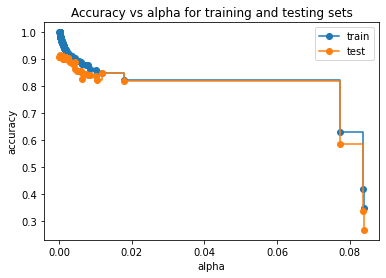

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

 DecisionBoundaryDisplay.from_estimator(
        clf,
        X_train,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        )

#### Multi Layer Perceptron

In [ ]:
X_data, X_train, y_train, X_test, y_test = get_split_train_test(wide_tab, ['diff_Roll', 'diff_Pitch', 'diff_Yaw'])
scaler = StandardScaler()

scaler.fit(X_train)

scaler.transform(X_train)
scaler.transform(X_test)


MLP = MLPClassifier(activation='logistic',hidden_layer_sizes=(100,), alpha = 0.01, max_iter = 1000)
MLP.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.01, max_iter=1000)

In [ ]:
MLP.score(X_test, y_test)

0.9275622912920627

In [ ]:
pickle.dump(rf_tab, open('classifiers/MLP_neutral_orientation_3s.pkl', 'wb'))

In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import classification_report

# # Définir votre pipeline avec le prétraitement des données
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # Normalisation des données
#     ('mlp', MLPClassifier())  # Classifier MLP
# ])

# # Définir la grille de paramètres à explorer
# param_grid = {
#     'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Taille des couches cachées
#     'mlp__activation': ['relu', 'tanh', 'logistic'],  # Fonction d'activation
#     'mlp__alpha': [0.0001, 0.001, 0.01],  # Paramètre de régularisation L2
#     'mlp__max_iter': [200, 300, 400],  # Nombre maximal d'itérations
# }

# # Initialiser la recherche par grille
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# # Exécuter la recherche par grille sur vos données
# grid_search.fit(X_train, y_train)  # X_train et y_train sont vos données d'entraînement

# # Afficher les meilleurs paramètres et le meilleur score
# print("Meilleurs paramètres trouvés :")
# print(grid_search.best_params_)
# print("Meilleur score sur le jeu de validation croisée :")
# print(grid_search.best_score_)

# # Prédire les étiquettes sur le jeu de test
# y_pred = grid_search.predict(X_test)  # X_test est votre ensemble de test

# # Afficher le rapport de classification
# print("Rapport de classification sur le jeu de test :")
# print(classification_report(y_test, y_pred))  # y_test sont les vraies étiquettes


Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\tdufl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.



Meilleurs paramètres trouvés :
{'mlp__activation': 'logistic', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__max_iter': 400}
Meilleur score sur le jeu de validation croisée :
0.8972345531208126
Rapport de classification sur le jeu de test :
              precision    recall  f1-score   support

     Neutral       1.00      0.97      0.98       287
       Pitch       0.93      0.96      0.95      1264
        Roll       0.96      0.96      0.96      1129
         Yaw       0.95      0.93      0.94      1505

    accuracy                           0.95      4185
   macro avg       0.96      0.95      0.96      4185
weighted avg       0.95      0.95      0.95      4185



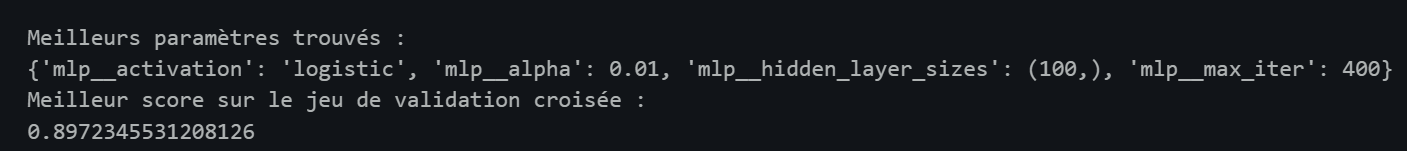
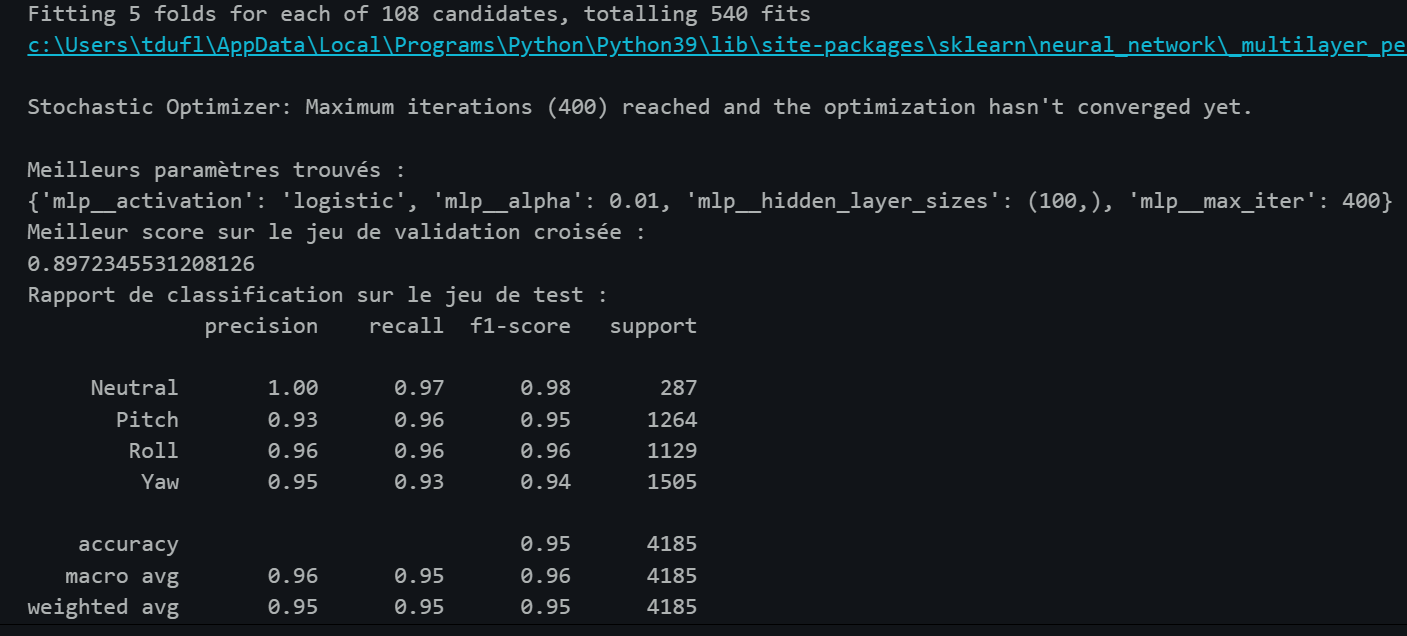